In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rounding = "round"):
    in_feature = 1024
    out_feature = 1024
    bias = True

    input = (torch.rand(256, in_feature) - 0.5).to(device)

    fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
    fc_o = fc(input)
    
    ufc_err_min_list = []
    ufc_err_max_list = []
    ufc_err_mean_list = []
    ufc_err_std_list = []

    ffc_err_min_list = []
    ffc_err_max_list = []
    ffc_err_mean_list = []
    ffc_err_std_list = []
    
    x_label = []
    
    for bitwidth in range(6, 13): 
        cycle = 2**(bitwidth-1)

        ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
        ufc_o = ufc(input)

        ffc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, rounding=rounding).to(device)
        ffc_o = ffc(input)

        ufc_err = (ufc_o - fc_o)
        ffc_err = (ffc_o - fc_o)
        
        ufc_err_min_list.append(ufc_err.min().item())
        ufc_err_max_list.append(ufc_err.max().item())
        ufc_err_mean_list.append(ufc_err.mean().item())
        ufc_err_std_list.append(ufc_err.std().item())
        
        ffc_err_min_list.append(ffc_err.min().item())
        ffc_err_max_list.append(ffc_err.max().item())
        ffc_err_mean_list.append(ffc_err.mean().item())
        ffc_err_std_list.append(ffc_err.std().item())
        
        x_label.append(bitwidth)
        
    return ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ffc_err_min_list, ffc_err_max_list, ffc_err_mean_list, ffc_err_std_list, x_label


In [5]:
rounding = "round"
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ffc_err_min_list, ffc_err_max_list, ffc_err_mean_list, ffc_err_std_list, x_label = test(rounding)
print(ufc_err_min_list)
print(ufc_err_max_list)
print(ufc_err_mean_list)
print(ufc_err_std_list)

print(ffc_err_min_list)
print(ffc_err_max_list)
print(ffc_err_mean_list)
print(ffc_err_std_list)

print(x_label)

[-0.07318973541259766, -0.03875201940536499, -0.01970905065536499, -0.010583639144897461, -0.005261600017547607, -0.00242459774017334, -0.0013068318367004395]
[0.07448014616966248, 0.040658265352249146, 0.018283814191818237, 0.009488910436630249, 0.004703491926193237, 0.0024523138999938965, 0.0014784932136535645]
[1.240038727701176e-05, 8.535403139831033e-06, 3.923956683138385e-06, 4.921172148897313e-06, 1.4362797173816944e-06, -2.676207486729254e-07, 8.118137202473008e-07]
[0.016648154705762863, 0.008498837240040302, 0.004322628956288099, 0.0022055471781641245, 0.001121089793741703, 0.0005716715240851045, 0.00029524913406930864]
[-0.017802521586418152, -0.00805724784731865, -0.004044488072395325, -0.0024314746260643005, -0.0010997522622346878, -0.0006002187728881836, -0.00019629299640655518]
[0.017983868718147278, 0.008218728005886078, 0.004349732771515846, 0.0021945014595985413, 0.0010267728939652443, 0.0006246808916330338, 0.00019412487745285034]
[1.0835673492692877e-05, 2.241844867

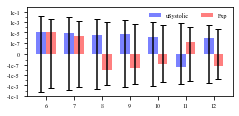

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1.6
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)
means2 = np.array(ffc_err_mean_list)
stds2 = np.array(ffc_err_std_list)
mins2 = np.array(ffc_err_min_list)
maxs2 = np.array(ffc_err_max_list)
x_label = np.array(x_label)

width = 0.35
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.bar(x-width/2, means1, width, yerr=stds1, align='center', alpha=1, capsize=3, color="#7A81FF", label="uSystolic")
ax.bar(x+width/2, means2, width, yerr=stds2, align='center', alpha=1, capsize=3, color="#FF7F7F", label="Fxp")
ax.set_xticks(x)
ax.set_xticklabels(x_label)

ax.set_yscale('symlog', linthresh=10**(-8))
ax.set_ylim(-0.1, 0.99)
ax.set_yticks([-10**(-1), -10**(-3), -10**(-5), -10**(-7), 0, 10**(-7), 10**(-5), 10**(-3), 10**(-1)])
# ax.set_yticklabels([-10**(-2), -10**(-4), -10**(-6), -10**(-8), 0, 10**(-8), 10**(-6), 10**(-4), 10**(-2)])
ax.set_yticklabels(["-1e-1", "-1e-3", "-1e-5", "-1e-7", "0", "1e-7", "1e-5", "1e-3", "1e-1"])
ax.legend(loc="upper right", ncol=2, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare.pdf", bbox_inches='tight', dpi=my_dpi)
